# Fake News Detection
**Автор:** Елизавета Клыкова
## Business Understanding
**Цель:**

Создать алгоритм для определения фейковых новостей (бинарная классификация: real vs. fake).

**Актуальность:**

Чем опасны фейковые новости?
- вред здоровью или жизни
- вред репутации человека или компании
- вред экономике (напр., манипуляция фондовыми рынками)
- манипуляция общественным мнением
- подрыв доверия к СМИ
- нарушение функционирования здоровой демократии

**Потенциальные способы применения:**

1. Агрегатор новостей с верификацией: сервис, который проверяет подлинность новостных статей и предоставляет пользователям рейтинг достоверности статьи. Это позволит пользователям получить доступ к тщательно отобранной ленте новостных статей, проверенных на их точность.

2. Анализ предвзятости СМИ: анализ и категоризация новостных статей определенного источника с точки зрения их политической/идеологической предвзятости.

3. Мониторинг репутации бренда: отслеживание потенциально фейковых новостей, которые могут нанести ущерб репутации бренда.

4. Образовательный инструмент: платформа, которая помогает людям учиться распознавать поддельные новости, критически оценивать источники новостей и отделять факты от вымысла.

In [93]:
# !pip install imbalanced-learn
# !pip install wordcloud

In [94]:
import random
from collections import Counter

import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler

import nltk
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Data Understanding
[Ссылка на датасет](https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification)

>WELFake is a dataset of 72,134 news articles (35,028 real and 37,106 fake) from four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political).  
>The dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).  
> Published in: IEEE Transactions on Computational Social Systems, pp. 1-13 (DOI: 10.1109/TCSS.2021.3068519).

In [95]:
data = pd.read_csv('WELFake_Dataset.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.shape

(72134, 3)

In [96]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


### Пустые строки

In [97]:
data.isna().any()

title     True
text      True
label    False
dtype: bool

In [98]:
data.isna().sum()

title    558
text      39
label      0
dtype: int64

Пустых строк не очень много относительно всего объема датасета, поэтому выбросим их, чтобы не мучиться.

In [99]:
data.dropna(inplace=True)
data.shape

(71537, 3)

### Дубли

In [100]:
len(data[data.duplicated()])

8416

Многовато, выбросим и их.

In [101]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

### Препроцессинг (токенизация, удаление пунктуации, приведение к нижнему регистру)
Токенизируем тексты с помощью NLTK и посмотрим на облако частотных слов для каждого типа новостей (реальных и фейковых).

In [102]:
TOKENIZER = nltk.RegexpTokenizer(r'[\da-zA-Z]+')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))


def preprocess_text(text, tokenizer=TOKENIZER, stopwords=STOPWORDS):
    """
    Предобрабатывает текст: приводит к нижнему регистру, удаляет все не-буквы и
    не-числа, токенизирует и очищает от стоп-слов.
    :param text: исходный текст
    :param tokenizer: способ токенизации
    :param stopwords: стоп-слова
    :return: очищенный текст или np.nan, если после очистки текст стал пустым
    """
    tokens = tokenizer.tokenize(text.lower().strip())
    no_stops = [tok for tok in tokens if tok not in stopwords]
    if no_stops:
        return no_stops
    return np.nan

In [103]:
data['tokens'] = data['text'].map(preprocess_text)

In [104]:
data.isna().any()

title     False
text      False
label     False
tokens     True
dtype: bool

In [105]:
data.isna().sum()

title       0
text        0
label       0
tokens    543
dtype: int64

После очистки текстов появились пустые строки -- выбросим их.

In [106]:
data.dropna(inplace=True)
data.shape

(62578, 4)

In [107]:
fake = data[data['label'] == 0]
real = data[data['label'] == 1]

fake_texts = ' '.join([' '.join(text) for text in fake['tokens']])
real_texts = ' '.join([' '.join(text) for text in real['tokens']])

### Облако слов

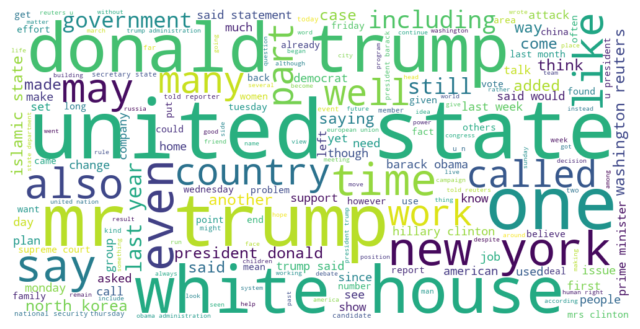

In [108]:
wordcloud = WordCloud(background_color='white',
                      stopwords=STOPWORDS,
                      max_words=200,
                      width=1000,
                      height=500).generate(fake_texts)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

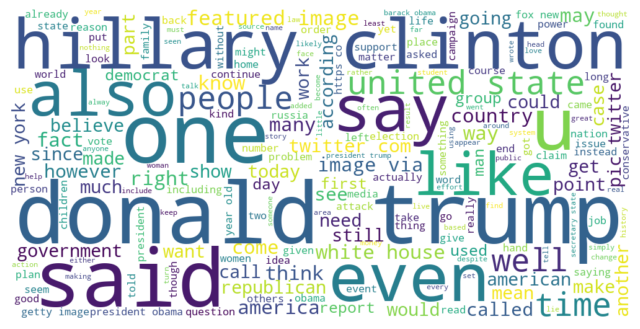

In [109]:
wordcloud = WordCloud(background_color='white',
                      stopwords=STOPWORDS,
                      max_words=200,
                      width=1000,
                      height=500).generate(real_texts)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Распределение частотностей немного разное, но слова в целом похожи, так что можно не переживать, что модель выучит 1-2 самых частотных слова для каждой категории и будет предсказывать результат по ним.

### Длина текстов

In [110]:
data['text_len'] = data['tokens'].apply(lambda x: len(x))

In [111]:
data.groupby('label')['text_len'].mean()

label
0    336.366581
1    295.843247
Name: text_len, dtype: float64

(0.0, 1000.0)

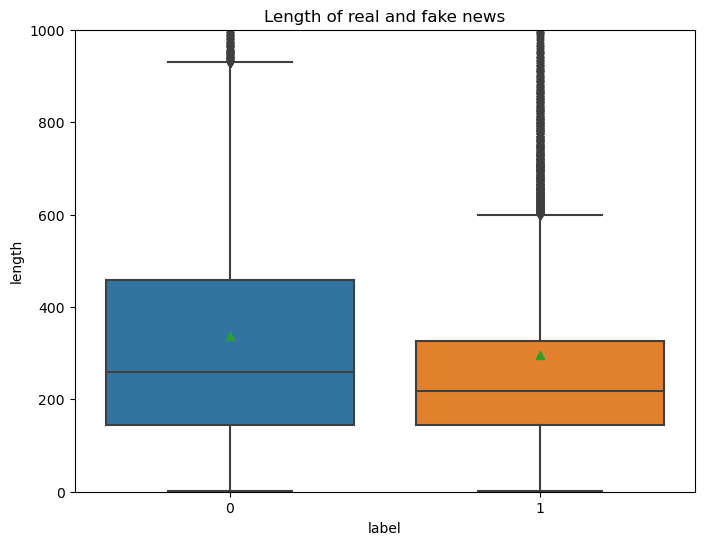

In [112]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='text_len', data=data, showmeans=True)
plt.title('Length of real and fake news')
plt.ylabel('length')
plt.xlabel('label')
plt.ylim(0, 1000)

Фейковые новости в среднем длиннее и имеют больший разброс по длине.

### Специфичные слова
Наконец, посмотрим на частотные слова, встречающиеся только в реальных или только в фейковых новостях.

In [113]:
fake_words = Counter(fake_texts.split())  # частотный словарь
fake_set = set(fake_words.keys())  # множество слов в фейковых новостях
fake_len = data['label'].value_counts()[0]  # число фейковых текстов

real_words = Counter(real_texts.split())
real_set = set(real_words.keys())
real_len = data['label'].value_counts()[1]

In [114]:
common_fake_words = {}
for word in fake_words:
    if word not in real_set:
        common_fake_words[word] = round(fake_words[word] / fake_len, 5)

In [115]:
common_real_words = {}
for word in real_words:
    if word not in fake_set:
        common_real_words[word] = round(real_words[word] / real_len, 5)

In [116]:
Counter(common_fake_words).most_common(15)

[('rakhine', 0.0261),
 ('mnangagwa', 0.01135),
 ('tmsnrt', 0.0096),
 ('marawi', 0.00828),
 ('barnier', 0.00813),
 ('babis', 0.0077),
 ('durst', 0.00733),
 ('pamkeynen', 0.00684),
 ('kem', 0.0063),
 ('sokha', 0.00624),
 ('awrhawkins', 0.00604),
 ('koike', 0.00546),
 ('lighthizer', 0.00535),
 ('ldp', 0.00529),
 ('antidoping', 0.0052)]

In [117]:
Counter(common_real_words).most_common(15)

[('21wire', 0.0402),
 ('quot', 0.0362),
 ('somodevilla', 0.01731),
 ('2017the', 0.01666),
 ('filessupport', 0.01069),
 ('mcnamee', 0.01026),
 ('angerer', 0.01018),
 ('youtu', 0.01008),
 ('2017trump', 0.00986),
 ('2016the', 0.00907),
 ('trunews', 0.00907),
 ('sheeple', 0.009),
 ('auf', 0.00878),
 ('wikimedia', 0.00853),
 ('sich', 0.00813)]

Похоже, что это в основном какой-то мусор, к тому же не самый частотный. Можно никак с ним не бороться.

### Распределение классов
0 = fake, 1 = real

In [118]:
data['label'].value_counts()

0    34789
1    27789
Name: label, dtype: int64

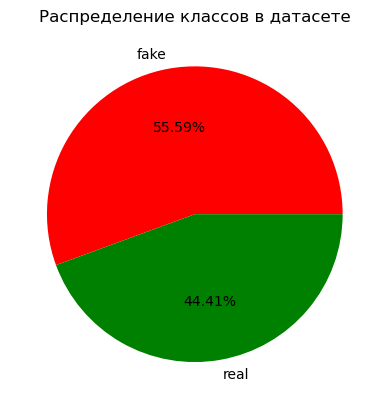

In [119]:
plt.pie(data['label'].value_counts().tolist(),
        labels=['fake', 'real'], colors=['red', 'green'],
        autopct='%1.2f%%')
plt.title('Распределение классов в датасете')
plt.show()

В целом это удачное распределение, но так как у нас много данных, создадим сэмпл с отношением классов 1:1.

In [120]:
data = data.sample(frac=1, random_state=SEED).reset_index(drop=True)

rus = RandomUnderSampler(sampling_strategy='not minority', random_state=SEED)
data_sample, balanced_labels = rus.fit_resample(data, data['label'])

data_sample = data_sample.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [121]:
data_sample.shape

(55578, 5)

In [122]:
data_sample.head()

,title,text,label,tokens,text_len
0,COVER-UP? New Details from Orlando Shooter’s C...,Shawn Helton 21st Century WireEarlier this we...,1,"[shawn, helton, 21st, century, wireearlier, we...",1679
1,HERE YOU GO: HILLARY’S E-MAILS FOR YOUR READIN...,Here are the e-mails released last night that ...,1,"[e, mails, released, last, night, confirm, kne...",47
2,WHERE WAS MEDIA OUTRAGE After This WOMAN DELIB...,The media has been giving wall-to-wall coverag...,1,"[media, giving, wall, wall, coverage, horrific...",575
3,Arab League to hold emergency meeting on Jerus...,CAIRO (Reuters) - The Arab League is to hold a...,0,"[cairo, reuters, arab, league, hold, emergency...",37
4,British banker to appeal conviction over HK do...,HONG KONG (Reuters) - Former British banker Ru...,0,"[hong, kong, reuters, former, british, banker,...",153


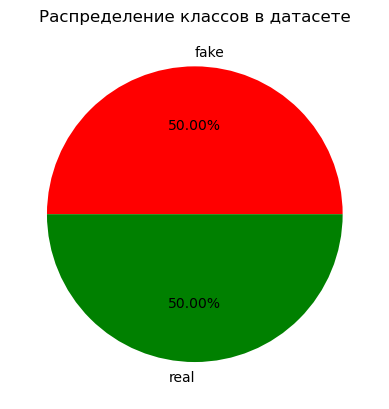

In [123]:
plt.pie(data_sample['label'].value_counts().tolist(),
        labels=['fake', 'real'], colors=['red', 'green'],
        autopct='%1.2f%%')
plt.title('Распределение классов в датасете')
plt.show()

### Train/test split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(data_sample[['tokens']],
                                                    data_sample['label'], 
                                                    train_size=0.75,
                                                    random_state=SEED)

## Baseline
Поскольку у нас бинарная классификация с распределением классов 1:1, в качестве бейзлайна используем рандомное предсказание 0 и 1.

In [125]:
random_preds = [random.randint(0, 1) for i in range(len(y_test))]
f'Random baseline accuracy: {accuracy_score(y_test, random_preds):.2f}'

'Random baseline accuracy: 0.50'

Вполне ожидаемое значение))

### Векторизация
Поскольку нам интересно выделять текстовые фичи, свойственные разным классам новостей, используем TF-IDF.

In [126]:
vectorizer = TfidfVectorizer(max_features=500,
                             tokenizer=lambda x: x,  # dummy, т.к. у нас уже токены
                             preprocessor=lambda x: x)

X_train = vectorizer.fit_transform(X_train['tokens'].tolist())
X_test = vectorizer.transform(X_test['tokens'].tolist())

Начнем с самого простого -- логистической регрессии без подбора гиперпараметров.

In [127]:
def evaluate_model(classifier, X_test, y_test):
    """
    Подсчитывает метрики для заданной модели на тестовом датасете.
    :param classifier: модель-классификатор
    :param X_test: данные для предсказания
    :param y_test: реальные значения
    :return: предсказанные значения и словарь метрик
    """
    y_pred = classifier.predict(X_test)
    metrics_dict = {'accuracy': round(accuracy_score(y_test, y_pred), 4),
                    'precision': round(precision_score(y_test, y_pred), 4),
                    'recall': round(recall_score(y_test, y_pred), 4),
                    'f1_score': round(f1_score(y_test, y_pred), 4)}
    print(f'Accuracy: {metrics_dict["accuracy"]}')
    print(f'Precision: {metrics_dict["precision"]}')
    print(f'Recall: {metrics_dict["recall"]}')
    print(f'F1-score: {metrics_dict["f1_score"]}')
    return y_pred, metrics_dict

In [128]:
logreg = LogisticRegression(random_state=SEED)
logreg = logreg.fit(X_train, y_train)

print('Metrics for Logistic Regression (no hyperparameter tuning)')
y_pred, logreg_def_metrics = evaluate_model(logreg, X_test, y_test)

Metrics for Logistic Regression (no hyperparameter tuning)
Accuracy: 0.9233
Precision: 0.919
Recall: 0.928
F1-score: 0.9235


In [129]:
def show_heatmap(y_test, y_pred):
    """
    Строит heatmap по предсказанным и реальным значениям.
    :param y_test: реальные значения
    :param y_pred: предсказанные значения
    :return: None (выводит график)
    """
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

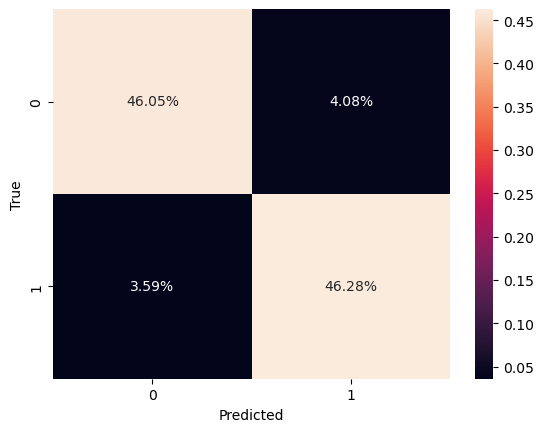

In [130]:
show_heatmap(y_test, y_pred)

Видим, что ошибок достаточно мало, причем для реальных и фейковых новостей их примерно одинаковое количество (около 4%). Не уверена, что получится значимо это улучшить, но попробуем.

## Modeling
Попробуем гридсерч по гиперпараметрам разных моделей.
### Логистическая регрессия

In [131]:
logreg = LogisticRegression()
logreg_params = {'penalty': ['l1', 'l2', 'elasticnet', None],
                 'C': [0.0001, 0.001, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
                 'fit_intercept': [True, False],
                 'random_state': [SEED],
                 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                 'max_iter': [100, 200, 500]}
logreg_cv = GridSearchCV(logreg,
                         param_grid=logreg_params,
                         cv=5,
                         n_jobs=-1)
logreg_cv.fit(X_train, y_train)

print('Best score for Logistic Regression: {}'.format(logreg_cv.best_score_))
print('Best parameters for Logistic Regression: {}'.format(logreg_cv.best_params_))

Best score for Logistic Regression: 0.9278362136782656
Best parameters for Logistic Regression: {'C': 1.5, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}


In [132]:
logreg = LogisticRegression(**logreg_cv.best_params_)
logreg = logreg.fit(X_train, y_train)

print('Metrics for Logistic Regression (with hyperparameter tuning)')
y_pred, logreg_tuned_metrics = evaluate_model(logreg, X_test, y_test)

Metrics for Logistic Regression (with hyperparameter tuning)
Accuracy: 0.9279
Precision: 0.9237
Recall: 0.9325
F1-score: 0.928


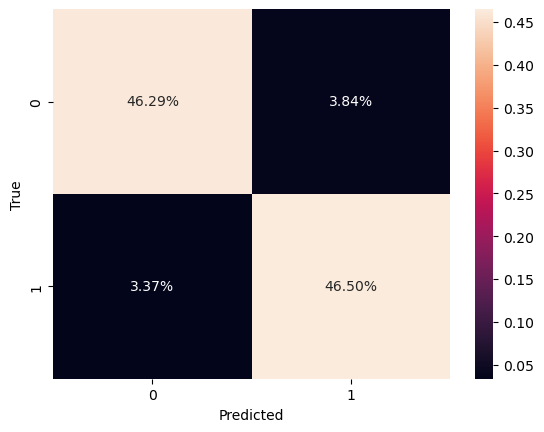

In [133]:
show_heatmap(y_test, y_pred)

Разница минимальная, но положительная. Попробуем другой классификатор.

### Мультиномиальный Байес

In [134]:
mnb = MultinomialNB()
mnb_params = {'alpha': [0.0001, 0.001, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]}
mnb_cv = GridSearchCV(mnb,
                      param_grid=mnb_params,
                      cv=5,
                      n_jobs=-1)
mnb_cv.fit(X_train, y_train)

print('Best score for Multinomial Naive Bayes: {}'.format(mnb_cv.best_score_))
print('Best parameters Multinomial Naive Bayes: {}'.format(mnb_cv.best_params_))

Best score for Multinomial Naive Bayes: 0.8455485594016177
Best parameters Multinomial Naive Bayes: {'alpha': 0.5}


In [135]:
mnb = MultinomialNB(**mnb_cv.best_params_)
mnb = mnb.fit(X_train, y_train)

print('Metrics for Multinomial Naive Bayes (with hyperparameter tuning)')
y_pred, mnb_tuned_metrics = evaluate_model(mnb, X_test, y_test)

Metrics for Multinomial Naive Bayes (with hyperparameter tuning)
Accuracy: 0.8493
Precision: 0.8378
Recall: 0.8653
F1-score: 0.8513


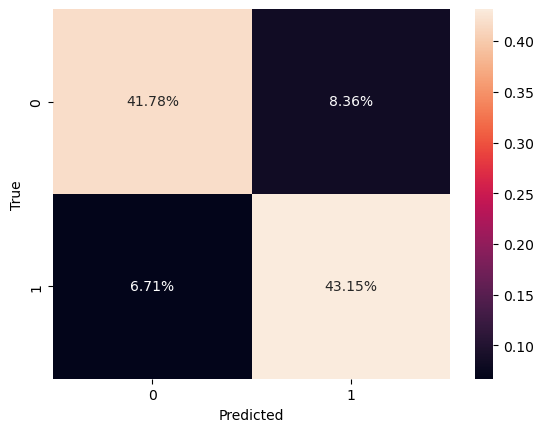

In [136]:
show_heatmap(y_test, y_pred)

Стало хуже :( попробуем что-то еще.

### Random Forest Classifier

In [66]:
rfc = RandomForestClassifier()
rfc_params = {'n_estimators': [10, 50, 100, 200],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'bootstrap': [True, False],
              'oob_score': [True, False],
              'random_state': [SEED]}
rfc_cv = GridSearchCV(rfc,
                      param_grid=rfc_params,
                      cv=5,
                      n_jobs=-1)
rfc_cv.fit(X_train, y_train)

print('Best score for Random Forest: {}'.format(rfc_cv.best_score_))
print('Best parameters Random Forest: {}'.format(rfc_cv.best_params_))

Best score for Random Forest: 0.9297555419185615
Best parameters Random Forest: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 200, 'oob_score': False, 'random_state': 42}


In [137]:
rfc = RandomForestClassifier(**rfc_cv.best_params_)
rfc = rfc.fit(X_train, y_train)

print('Metrics for Random Forest Classifier (with hyperparameter tuning)')
y_pred, rfc_tuned_metrics = evaluate_model(rfc, X_test, y_test)

Metrics for Random Forest Classifier (with hyperparameter tuning)
Accuracy: 0.9303
Precision: 0.9135
Recall: 0.9501
F1-score: 0.9314


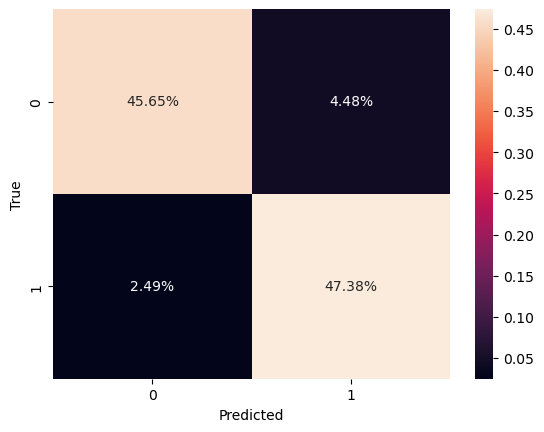

In [138]:
show_heatmap(y_test, y_pred)

Метрики немного выросли, но теперь больше фейковых новостей распознаются как реальные. Для выбора лучшего алгоритма нужно решить, что для нас важнее: выловить все фейки или не "обидеть" ни одну реальную новость.

## Results

In [139]:
metrics_for_df = [logreg_def_metrics, logreg_tuned_metrics,
                  mnb_tuned_metrics, rfc_tuned_metrics]
metrics_df = pd.DataFrame(metrics_for_df)
metrics_df['classifier'] = ['LogReg_default', 'LogReg_grid',
                            'MultiNB_grid', 'RandomForest_grid']
metrics_df.style.highlight_max(color='lightgreen', axis=0,
                               subset=['accuracy', 'precision', 'recall', 'f1_score'])

,accuracy,precision,recall,f1_score,classifier
0,0.923300,0.919000,0.928000,0.923500,LogReg_default
1,0.927900,0.923700,0.932500,0.928000,LogReg_grid
2,0.849300,0.837800,0.865300,0.851300,MultiNB_grid
3,0.930300,0.913500,0.950100,0.931400,RandomForest_grid


При изначально высоком качестве значимых улучшений не получилось (может быть, трансформеры смогли бы достичь 0.97+). Можно попробовать другую векторизацию (тот же CountVectorizer или Doc2Vec), можно как-то использовать названия новостных статей, можно прочитать исследование авторов датасета и придумать что-то еще.

### Бонус
Тут можно классифицировать любой (английский) текст :)

In [140]:
def play_with_model(text, vectorizer, clf):
    """
    Предсказывает лейбл для произвольного текста.
    :param text: исходный текст
    :param vectorizer: TF-IDF vectorizer для векторизации текста
    :param clf: модель-классификатор
    :return: предсказанный класс
    """
    clean_text = preprocess_text(text)
    vec_text = vectorizer.transform([clean_text])
    prediction = clf.predict(vec_text)[0]
    if prediction:
        return 'real'
    return 'fake'

In [141]:
play_with_model('Trump is the president of Russia', vectorizer, rfc)

'real'